# CS 237 Fall 2020   Homework Nine Solution


### Due date: Due Friday April 10th at Midnight with 1 week grace period
 

### General Instructions

Please complete this notebook by filling in solutions where indicated. Be sure to "Run All" from the Cell menu before submitting. 


In [2]:
# General useful imports
import numpy as np
from numpy import arange,linspace,mean, var, std
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from numpy.random import seed, random, randint, uniform, choice, binomial, geometric, poisson, exponential, normal 
import math
from collections import Counter
import pandas as pd
%matplotlib inline


# Numpy basic stats functions

# https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.statistics.html


X = [1,2,3]

# mean of a list
mean(X)

# population variance
var(X)

# sample variance
var(X,ddof=1)

# population standard deviation
std(X)

# sample standard deviation
std(X,ddof=1)


# Scipy statistical functions

from scipy.stats import norm,expon,poisson 

# https://docs.scipy.org/doc/scipy/reference/stats.html

# given random variable X (e.g., housing prices) normally distributed with  mu = 60, sigma = 40

#a. Find P(X<50)
norm.cdf(x=50,loc=60,scale=40) # 0.4012936743170763

#b. Find P(X>50)
norm.sf(x=50,loc=60,scale=40) # 0.5987063256829237

#c. Find P(60<X<80)
norm.cdf(x=80,loc=60,scale=40) - norm.cdf(x=60,loc=60,scale=40)

# Same as previous but in one function: returns P(lo < X < hi)
def rangeNormal(lo,hi,loc,scale):
    return norm.cdf(x=hi,loc=loc,scale=scale) - norm.cdf(x=lo,loc=loc,scale=scale)

# Same as previous but prints it out
def printRangeNormal(lo,hi,loc,scale):
    p = norm.cdf(x=hi,loc=loc,scale=scale) - norm.cdf(x=lo,loc=loc,scale=scale)
    print("P(" + str(lo) + " < X < " + str(hi) + ") = " + str(round4(p)))

# Same as previous but prints out the inverse 
def printInverseRangeNormal(lo,hi,loc,scale):
    p = norm.cdf(x=hi,loc=loc,scale=scale) - norm.cdf(x=lo,loc=loc,scale=scale)
    q = (1-p)
    print("P( X < " + str(lo) + " OR " + str(hi) + " < X ) = " + str(round4(q)))

#d. how much top most 5% expensive house cost at least? or find x where P(X>x) = 0.05
norm.isf(q=0.05,loc=60,scale=40)

#e. how much top most 5% cheapest house cost at least? or find x where P(X<x) = 0.05
norm.ppf(q=0.05,loc=60,scale=40)

#f give the endpoints of the range for the central alpha percent of the distribution
norm.interval(alpha=0.3, loc=60, scale=140)

norm.rvs(loc=60,scale=14)

# Same for exponential distribution
lam = 0.2    # rate parameter

beta = 1/lam   # the mean 

expon.pdf(x=3,loc=0,scale=beta)       # don't change loc = starting point

expon.rvs(0,beta)


# functions from numpy.random library


# Utility functions

# Round to 4 decimal places
def round4(x):
    return np.around(x,4)


## Queue Simulation Code

The following code simulates a simple queue and server, in which tasks arrive at a FIFO queue and wait for service; after they complete their service, they leave the system. 

<img src="SimpleQueue.png" alt=""/>

Tasks are defined by two parameters, their service time (how long they need service) and their arrival time. The simulation is entirely determined by the list of tasks and their parameters. For this problem, several lists of tasks are given explicitly, and the first thing to do is to try each of these and understand what information is being output at the end:

   - A Gannt Chart showing over time what happens to each of the tasks as they arrive, wait in the queue, and get served.
   - Chart of CPU Utilization over time
   - Chart of the Queue Length over time
   - Distribution of the Queue Length (as a random variable)
   - Various quantitative measures from the simulation, namely,
       - totalTime -- just the time in seconds for the whole simulation
       - meanServiceTime -- the average over all tasks of the time they required for service (this was specified in the original task list, but the statistic is the mean over all tasks)
       - meanInterarrivalTime -- the average over all tasks of the intervals between arrivals
       - meanWaitTime -- the average over all tasks of the amount of time they spend waiting in the queue
       - cpuUtilization -- the percentage of time the server (CPU) is busy
       - meanQueueLength -- the expected value (mean) of the random variable representing the length of the queue over time
       - stdQueueLength -- the standard deviation of the random variable representing the length of the queue over time
   


In [3]:
# M/M/1 Queue Simulation

# task in list is [arrival time, service request, cpu start time]

# We assume in this simulation that no tasks arrive at the same time; you must specify the
# first two components, and the last is filled in by the simulation


def runSimulation(taskList):
    
    task = taskList.copy()

    front = 0
    next = 0          # when front == next, Q is empty
    cpu = -1          # when cpu == -1, CPU is empty
    
    t = 0       # clock
    
#    cpuUtil = []         # CPU utilization 
#    Q = []               # distribution of Q size
    
    while(front < len(task) or cpu != -1):
        # beginning of this time slice
        
        # if there is a next task which enters Q now, do so
        if(next < len(task) and task[next][0] == t):   
            next += 1
        # if CPU is empty and Q is not, move front of queue to CPU
        if(cpu == -1 and front != next):
            cpu = front             # move front of Q to cpu
            front += 1              # move front of Q to next task
            task[cpu][2] = t       # store cpu start time in task
            
                 
        # increment clock to next event
        # could be task arrival in Q or task finish in cpu
        
        nextCpuFinish = (task[cpu][1]+task[cpu][2])
        if(next < len(task) and cpu != -1):  
            if(task[next][0] < nextCpuFinish):   
                t = task[next][0]               # next is arrival of new task in Q
            else:
                t = nextCpuFinish                # next is cpu finish
                cpu = -1
        elif(next < len(task)):      
            t = task[next][0]               # next is arrival of new task in Q
        elif(cpu != -1): 
            t = nextCpuFinish                # last job has finished
            
        # end of this time slice
        
        # if task in CPU has finished, remove it
        if(nextCpuFinish == t):
            cpu = -1

    
#    print("\nFinished Tasks: " + str(task))
    
    # return completed task list and statistics
    # []
    return task


def E(X):
    (R,P) = X
    return sum(p*q for p,q in zip(R,P)) 
    
def Var(X):
    (R,P) = X
    mu = E(X)
    return E( ([(x-mu)**2 for x in R], P ))
    
def stdev(X):
    return (Var(X)**0.5)

# Print out list of tasks in nice format

def pprint(tasks):
    if len(tasks) == 0:
        print("Task list is empty.")
        return
    if(sum([w for [a,s,w] in tasks]) == 0):
        print("Task #\tStart\tService")
        print('0\t' +str(round4(tasks[0][0]))+'\t'+str(round4(tasks[0][1])))
    else:
        print("Task #\tStart\tService\tWait")
        print('0\t' +str(round4(tasks[0][0]))+'\t'+str(round4(tasks[0][1]))+'\t'+str(round4(tasks[0][2])))
    for k in range(1,len(tasks)):
        if(tasks[k][2] == 0):
            print(str(k)+'\t'+str(round4(tasks[k][0]))+'\t'+str(round4(tasks[k][1])))
        else:    
            wait_time = tasks[k][2] - tasks[k][0]
            print(str(k)+'\t'+str(round4(tasks[k][0]))+'\t'+str(round4(tasks[k][1]))+'\t'+str(wait_time))


def drawQDistribution(X, P):
    
    # This is the boundaries of the bins, they are half way between each
    #    of the discrete points in the sample set
    if(len(X) > 5):
        plt.figure(figsize=(15,3))    

    bins = [x-0.5 for x in range(min(X),max(X)+2)]

    plt.hist(X, bins, weights=P, ec='k')
    plt.xticks(X)
    plt.title("Distribution X of Queue Lengths")
    plt.ylabel("Probability")  
    plt.xlabel("Queue Lengths")
    plt.show()
    
    print("E[X]     = {0:.4f}".format(round(E((X,P)),4)))
    print("Var(X)   = {0:.4f}".format(round(Var((X,P)),4)))
    print("stdev(X) = {0:.4f}".format(round(stdev((X,P)),4)))


# this prints out the Gannt Chart and also prints out the
# probability distribution of the queue length

def displayResults(task): 
    
   # print("\nCompleted task list:" + str(task))
    print("\nNumber of Tasks: " + str(len(task)))
    totalTime = task[-1][2]+task[-1][1]
    print("\nTotal Time: " + str(round4(totalTime)))
    print("\n")
           
    # Print GANTT Chart
    
    fig = plt.figure(figsize=(15,10))
    fig.subplots_adjust(hspace=.5)
    ax1 = fig.add_subplot(311)       
    plt.yticks(range(len(task)))    
    plt.ylim((-0.5,len(task)))
    plt.title('GANNT Chart')
    plt.ylabel('Task Number')
    plt.xlabel('Time Slot')    
      
    for k in range(len(task)):
        plt.hlines(k, task[k][0], task[k][2], color='C0',linestyle='dotted',linewidth=4)
        plt.hlines(k, task[k][2], task[k][1]+task[k][2], color='C0',linestyle='solid',linewidth=4) 
    
    # Determine means of various parameters
    
    sumService = 0
    for i in range(len(task)):
        sumService += task[i][1] 
    
    meanServiceTime = sumService / len(task)
    
    sumInterarrival = 0
    for i in range(1,len(task)):
         sumInterarrival += task[i][0] - task[i-1][0] 
    
    meanInterarrivalTime =  sumInterarrival / len(task)
    
    sumWait = 0
    for i in range(len(task)):
        sumWait += task[i][2] - task[i][0]
        
    meanWaitTime = sumWait / len(task)
    
    sumService = 0
    for i in range(len(task)):
        sumService += task[i][1]
        
    cpuUtilization = sumService / totalTime
    
    # Now figure out CPU utilization in each time slot

    # first figure out all possible cpu event times
    
    bins = []
    
    for k in range(len(task)):
        bins.append(task[k][2])
        bins.append(task[k][1]+task[k][2])
       
    bins = list(set(bins))
    bins.sort()
    
    X = []
    for i in range(len(task)):
        X.append(task[i][2]) 
    
   
    # Display CPU Utilization Chart
    
    fig.add_subplot(312,sharex=ax1)
    plt.hist(X,bins,ec='k')    
    plt.title('CPU Utilization')    
    plt.ylabel('Usage')
    plt.xlabel('Time Slot')    
    plt.ylim((0,1.25))
   
    # Calculate Queue Length Distribution over time slots and by length
    
    bins = []
    
    for k in range(len(task)):
        bins.append(task[k][0])        # only add times when q changes
        bins.append(task[k][2])
       
    bins = list(set(bins))
    bins.sort()
    
    
    X = []      # X will have bin start times, repeated for each arrival in queue

    totalTime = task[-1][1]+task[-1][2]
    
    binProbabilities = [(bins[i]-bins[i-1])/totalTime for i in range(1,len(bins))]
#    # add last probability for last bin (when last task in cpu)
    binProbabilities.append(1-sum(binProbabilities))
    binCount = [0]*(len(bins))     # how many tasks in queue in each bin
     
    for k in range(len(bins)):
        for i in range(len(task)):
            if(task[i][0] <= bins[k] < task[i][2]):
                binCount[k] += 1
                X.append(bins[k]) 

#    print(X)
#    print(binCount)
   
    fig.add_subplot(313,sharex=ax1) 
    plt.hist(X,bins,ec='k')
    plt.title('Queue Length over Time')
    plt.ylabel('Length of Queue')
    plt.xlabel('Time Slot')
    plt.show()
    
# Now calculate the probability distribution of the queue lengths
    limit = 100
    length = min(limit,max(binCount))+1
    P = [0]*length   # P will be probability distribution for range 0 .. 99

    for k in range(len(bins)):
        if(binCount[k] < limit):
            P[binCount[k]] += binProbabilities[k]

    drawQDistribution(range(length),P)
    print("\nMean Service Time: " + str(round4(meanServiceTime)))
    print("\nMean Interarrival Time: " + str(round4(meanInterarrivalTime)))
    print("\nCPU Utilization: " + str(round4(cpuUtilization)))
    print("\nMean Wait Time: " + str(round4(meanWaitTime)))
    

# Return a pair (X,P) which is the distribution of the queue lengths    
def getQueueDistribution(task):
    
    bins = []
    
    for k in range(len(task)):
        bins.append(task[k][0])        # only add times when q changes
        bins.append(task[k][2])
       
    bins = list(set(bins))
    bins.sort()
        
    X = []      # X will have bin start times, repeated for each arrival in queue

    totalTime = task[-1][1]+task[-1][2]
    
    binProbabilities = [(bins[i]-bins[i-1])/totalTime for i in range(1,len(bins))]
#    # add last probability for last bin (when last task in cpu)
    binProbabilities.append(1-sum(binProbabilities))
    binCount = [0]*(len(bins))     # how many tasks in queue in each bin
     
    for k in range(len(bins)):
        for i in range(len(task)):
            if(task[i][0] <= bins[k] < task[i][2]):
                binCount[k] += 1
                X.append(bins[k]) 


    
# Now calculate the probability distribution of the queue lengths
    limit = 100
    length = min(limit,max(binCount))+1
    P = [0]*length   # P will be probability distribution for range 0 .. 99

    for k in range(len(bins)):
        if(binCount[k] < limit):
            P[binCount[k]] += binProbabilities[k]

    return ([x for x in range(length)],P)
    
def analyzeResults(task): 
    
    totalTime = task[-1][2]+task[-1][1]

    
    sumService = 0
    for i in range(len(task)):
        sumService += task[i][1] 
    
    meanServiceTime = sumService / len(task)
    
    sumInterarrival = 0
    for i in range(1,len(task)):
         sumInterarrival += task[i][0] - task[i-1][0] 
    
    meanInterarrivalTime =  sumInterarrival / len(task)
    
    sumWait = 0
    for i in range(len(task)):
        sumWait += task[i][2] - task[i][0]
        
    meanWaitTime = sumWait / len(task)
    
    sumService = 0
    for i in range(len(task)):
        sumService += task[i][1]
        
    cpuUtilization = sumService / totalTime
    
    # Now figure out CPU utilization in each time slot

    # first figure out all possible cpu event times
    
    bins = []
    
    for k in range(len(task)):
        bins.append(task[k][2])
        bins.append(task[k][1]+task[k][2])
       
    bins = list(set(bins))
    bins.sort()
    
    X = []
    for i in range(len(task)):
        X.append(task[i][2]) 
    

   
    # Calculate Queue Length Distribution over time slots and by length
    
    bins = []
    
    for k in range(len(task)):
        bins.append(task[k][0])        # only add times when q changes
        bins.append(task[k][2])
       
    bins = list(set(bins))
    bins.sort()
    
    
    X = []      # X will have bin start times, repeated for each arrival in queue

    totalTime = task[-1][1]+task[-1][2]
    
    binProbabilities = [(bins[i]-bins[i-1])/totalTime for i in range(1,len(bins))]
#    # add last probability for last bin (when last task in cpu)
    binProbabilities.append(1-sum(binProbabilities))
    binCount = [0]*(len(bins))     # how many tasks in queue in each bin
     
    for k in range(len(bins)):
        for i in range(len(task)):
            if(task[i][0] <= bins[k] < task[i][2]):
                binCount[k] += 1
                X.append(bins[k]) 


# Now calculate the probability distribution of the queue lengths
    limit = 100
    length = min(limit,max(binCount))+1
    P = [0]*length   # P will be probability distribution for range 0 .. 99

    for k in range(len(bins)):
        if(binCount[k] < limit):
            P[binCount[k]] += binProbabilities[k]
    
    X = range(length)
    
    meanQueueLength = E((X,P))

    stdQueueLength = stdev((X,P))    
    
    
    return (totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization,meanQueueLength,stdQueueLength)
    



## Problem Zero

Your task for this first problem is to simply run the queueing simulation with four different examples, observing how the tasks produce different behaviors in the queue. In the next problem you will create your own example task list to produce a specified behavior. This is just warmup for the rest of the homework. 

First, run each of the example task lists ex0, ..., ex3 in the following code cell to see how they behave. Nothing to hand in, but **DO NOT SKIP THIS STEP.** 



Simulation Running ... 

Input Task List: [[0, 1, 0], [2, 2, 0], [3, 1, 0], [4, 3, 0], [5, 5, 0]]


-------------------------------------------------------------------------------------

Here is a display of the results of the simulation for illustration and debugging:


Number of Tasks: 5

Total Time: 13




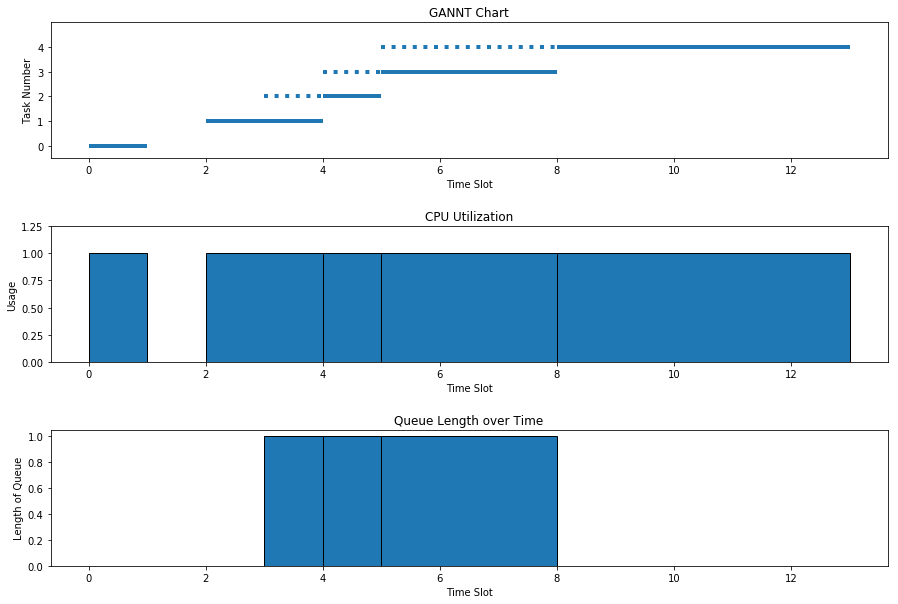

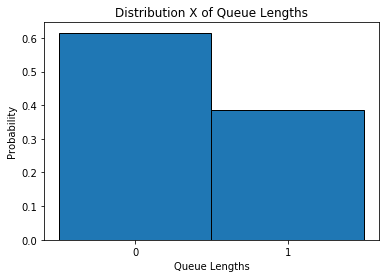

E[X]     = 0.3846
Var(X)   = 0.2367
stdev(X) = 0.4865

Mean Service Time: 2.4

Mean Interarrival Time: 1.0

CPU Utilization: 0.9231

Mean Wait Time: 1.0

-------------------------------------------------------------------------------------

Here is a display of the statistics collected by analyzeResults(...):


Completed Task List:
Task #	Start	Service	Wait
0	0	1	0
1	2	2	0
2	3	1	1
3	4	3	1
4	5	5	3

(totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization, meanQueueLength, stdQueueLength)

(13, 2.3999999999999999, 1.0, 1.0, 0.92310000000000003, 0.3846, 0.48649999999999999)


In [4]:
# Some simple examples of task lists to explore the basic ideas.
    
    
    # Simulation will fill in last component in task


ex0 = [[0,1,0], [2,2,0], [3,1,0], [4,3,0], [5,5,0]]

ex1 = [[0, 1.0, 0], [0.5, 0.3, 0], [1.4, 1, 0], [1.9, 0.25, 0], [2.0, 0.5, 0]]

ex2 = [[0,2.1,0], [1.9,2.34,0], [3.56,4.1,0], [4.12,3.4,0], [5.2,2.43,0]]

ex3 = [[0,2,0], [1.1,3,0], [3.4,4,0], [3.45,3,0], [5,3.23,0],[6.2,2.9,0],[6.4,2.32,0], [9.99,1.2,0], [10.3,3.4,0], [12.8,3.9,0], [15.2,3.4,0],
       [15.67,2.43,0],[17.01,2.8,0],[18.8,2.2,0],[20.1,2.99,0],[21.7,5.34,0],[24.4,2.2,0]]    

def displaySimulation(ex):
    print("\nSimulation Running ... \n")
    if len(ex) <= 20:
        print("Input Task List: " + str(ex)+'\n')
    completedTasks = runSimulation(ex)

    # The following will display various charts and print out the stats; this is just for illustration and
    # debugging
    print("\n-------------------------------------------------------------------------------------")
    print("\nHere is a display of the results of the simulation for illustration and debugging:\n")
    displayResults(completedTasks)

    # the following will not display anything, but just return the statistics
    (totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization,meanQueueLength,stdQueueLength) = analyzeResults(completedTasks)
    print("\n-------------------------------------------------------------------------------------")
    print("\nHere is a display of the statistics collected by analyzeResults(...):\n")
    print("\nCompleted Task List:")
    pprint(completedTasks)
    print("\n(totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization, meanQueueLength, stdQueueLength)\n")
    print((round4(totalTime), round4(meanServiceTime), round4(meanInterarrivalTime), round4(meanWaitTime), round4(cpuUtilization), round4(meanQueueLength), round4(stdQueueLength)))



displaySimulation( ex0 )      # <<== change this here

## Problem One 

### Part (A)

Now give a task list `ans1A` which will produce the following Gaant Chart. (Hint: all numbers involved are integers.)  

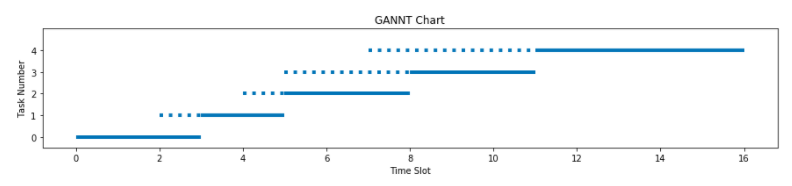


Simulation Running ... 

Input Task List: [[0, 3, 0], [2, 2, 0], [4, 3, 0], [5, 3, 0], [7, 5, 0]]


-------------------------------------------------------------------------------------

Here is a display of the results of the simulation for illustration and debugging:


Number of Tasks: 5

Total Time: 16




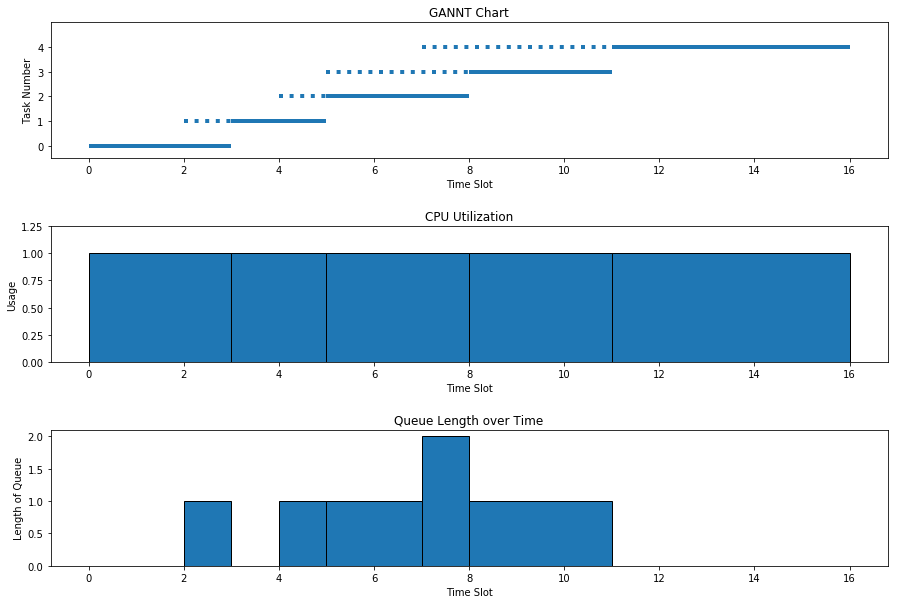

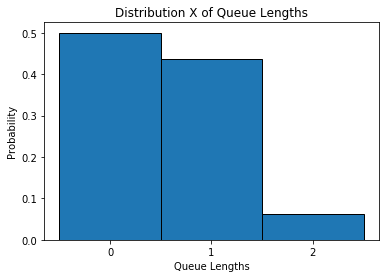

E[X]     = 0.5625
Var(X)   = 0.3711
stdev(X) = 0.6092

Mean Service Time: 3.2

Mean Interarrival Time: 1.4

CPU Utilization: 1.0

Mean Wait Time: 1.8

-------------------------------------------------------------------------------------

Here is a display of the statistics collected by analyzeResults(...):


Completed Task List:
Task #	Start	Service	Wait
0	0	3	0
1	2	2	1
2	4	3	1
3	5	3	3
4	7	5	4

(totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization, meanQueueLength, stdQueueLength)

(16, 3.2000000000000002, 1.3999999999999999, 1.8, 1.0, 0.5625, 0.60919999999999996)


In [5]:
# Your answer here:

ans1A = [[0,3,0], [2,2,0], [4,3,0], [5,3,0], [7,5,0]  ]

displaySimulation( ans1A )

### Part (B) 

Now give a task list which will produce the following "Queue Length over Time" chart:
    
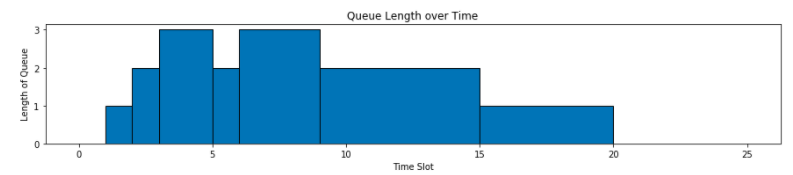

(Hint: all numbers involved are integers.)  


Simulation Running ... 

Input Task List: [[0, 5, 0], [1, 4, 0], [2, 6, 0], [3, 5, 0], [6, 5, 0]]


-------------------------------------------------------------------------------------

Here is a display of the results of the simulation for illustration and debugging:


Number of Tasks: 5

Total Time: 25




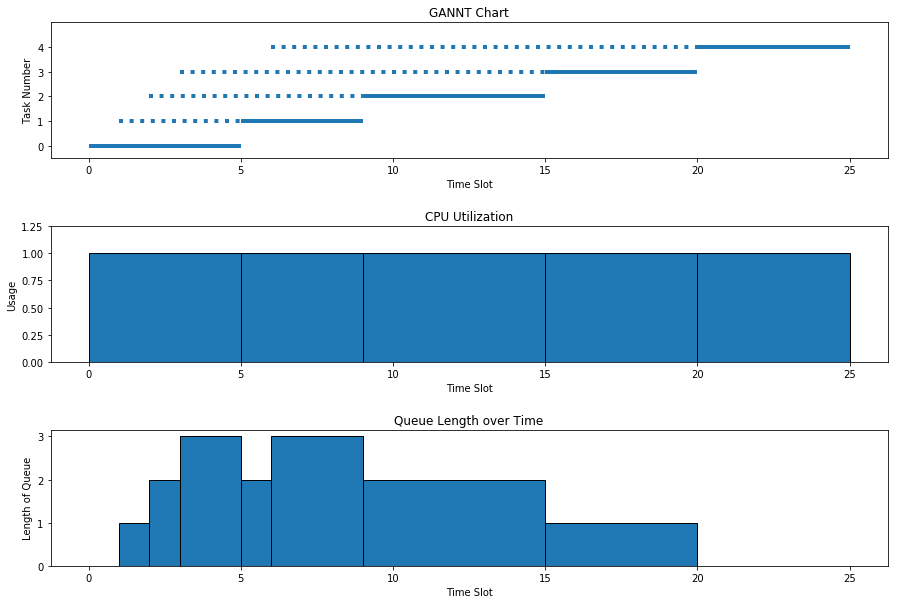

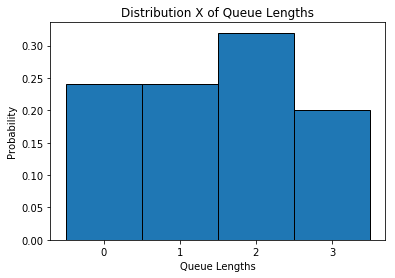

E[X]     = 1.4800
Var(X)   = 1.1296
stdev(X) = 1.0628

Mean Service Time: 5.0

Mean Interarrival Time: 1.2

CPU Utilization: 1.0

Mean Wait Time: 7.4

-------------------------------------------------------------------------------------

Here is a display of the statistics collected by analyzeResults(...):


Completed Task List:
Task #	Start	Service	Wait
0	0	5	0
1	1	4	4
2	2	6	7
3	3	5	12
4	6	5	14

(totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization, meanQueueLength, stdQueueLength)

(25, 5.0, 1.2, 7.4000000000000004, 1.0, 1.48, 1.0628)


In [6]:
ans1B = [[0,5,0], [1,4,0], [2,6,0], [3,5,0], [6,5,0] ]
    
displaySimulation( ans1B )

### Part (C) 

Now give a task list with 4 tasks which run for a total of 9 seconds, and will produce the following "Distribution X of Queue Lengths":

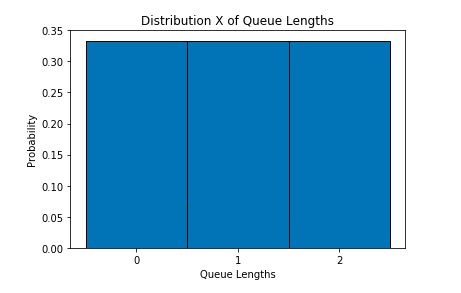
    
(In other words, the queue spends one third of its time empty, one third with one task, and one third with two tasks. Note that these do not have to be in any order, and the queue can bounce around a lot, but in the end, this must be the distribution of the queue lengths.)

(Hint: all numbers involved are integers.)  


Simulation Running ... 

Input Task List: [[0, 4, 0], [2, 3, 0], [3, 1, 0], [5, 1, 0]]


-------------------------------------------------------------------------------------

Here is a display of the results of the simulation for illustration and debugging:


Number of Tasks: 4

Total Time: 9




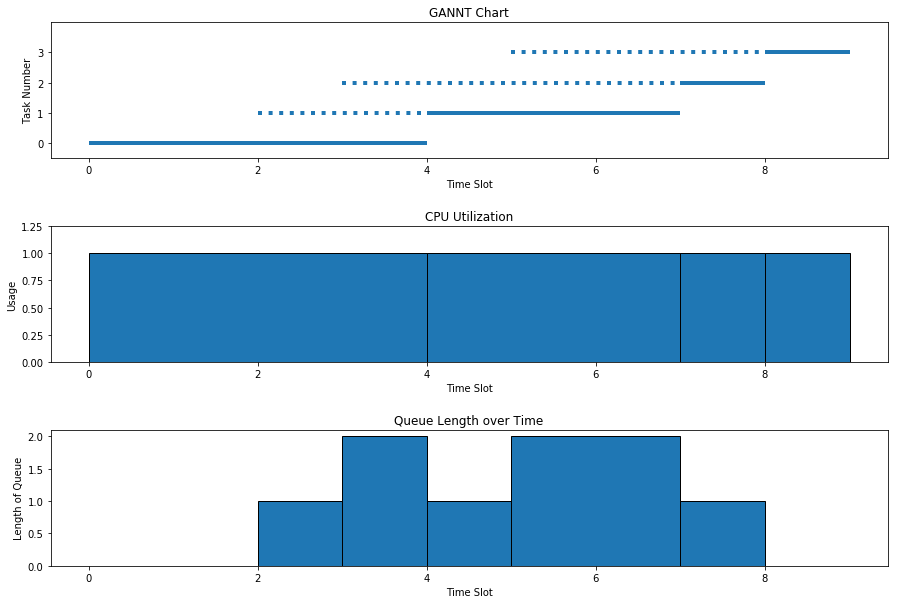

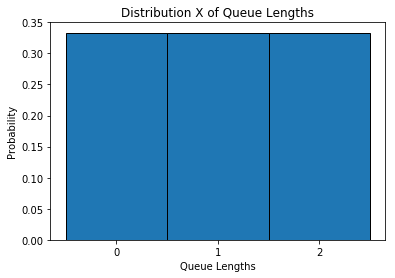

E[X]     = 1.0000
Var(X)   = 0.6667
stdev(X) = 0.8165

Mean Service Time: 2.25

Mean Interarrival Time: 1.25

CPU Utilization: 1.0

Mean Wait Time: 2.25

-------------------------------------------------------------------------------------

Here is a display of the statistics collected by analyzeResults(...):


Completed Task List:
Task #	Start	Service	Wait
0	0	4	0
1	2	3	2
2	3	1	4
3	5	1	3

(totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization, meanQueueLength, stdQueueLength)

(9, 2.25, 1.25, 2.25, 1.0, 1.0, 0.8165)


In [7]:
### Your answer here:

ans1C = [[0,4,0], [2,3,0], [3,1,0],[5,1,0]]

displaySimulation( ans1C )

### Part (D) 

Now give a task list with 4 tasks which will produce the following statistics at the end:
    
   -  (8, 1.0, 1.75, 0.0, 0.5, 0.0, 0.0)
   
(Hint: all numbers involved are integers.)  


Simulation Running ... 

Input Task List: [[0, 1, 0], [2, 1, 0], [4, 1, 0], [7, 1, 0]]


-------------------------------------------------------------------------------------

Here is a display of the results of the simulation for illustration and debugging:


Number of Tasks: 4

Total Time: 8




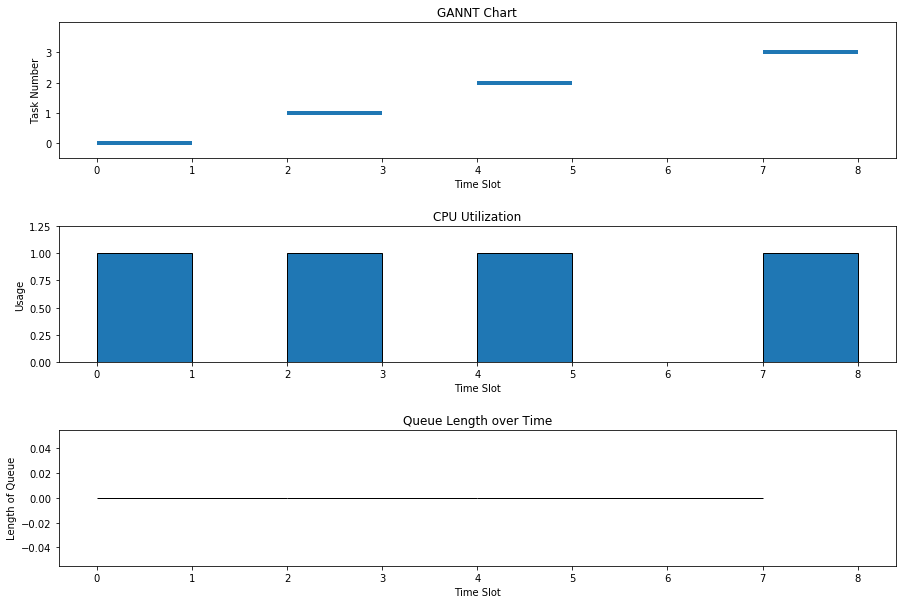

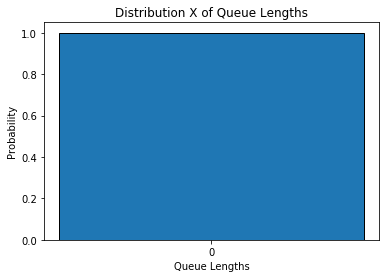

E[X]     = 0.0000
Var(X)   = 0.0000
stdev(X) = 0.0000

Mean Service Time: 1.0

Mean Interarrival Time: 1.75

CPU Utilization: 0.5

Mean Wait Time: 0.0

-------------------------------------------------------------------------------------

Here is a display of the statistics collected by analyzeResults(...):


Completed Task List:
Task #	Start	Service	Wait
0	0	1	0
1	2	1	0
2	4	1	0
3	7	1	0

(totalTime, meanServiceTime, meanInterarrivalTime, meanWaitTime, cpuUtilization, meanQueueLength, stdQueueLength)

(8, 1.0, 1.75, 0.0, 0.5, 0.0, 0.0)


In [8]:
# Your answer here:

ans1D = [[0,1,0], [2,1,0], [4,1,0],[7,1,0]]

displaySimulation( ans1D )

# Problem Two: Producing Exponentially Distributed Input Task Lists

Now you will write a function which will create a task list of N tasks, with exponentially-distributed arrival times and service times. The three parameters 
will be

    - N = how many tasks will enter the system
    - beta1 = the MEAN of the inter-arrival times ( = 1/lambda1 for some rate lambda1)
    - beta2 = the MEAN of the service times (etc.) 

(Therefore you can call `expon.rvs(0,beta1)` to generate the sequence of inter-arrival times; note that the actual timestamps of the arrival times will be created by having the first task arrive at time 0, and then adding together the interarrival times to get the actual arrival time.)

You must complete the stub `getTaskList(N,beta1,beta2)` below which does the following:

   - create a list of N tasks
   - each task will be a list of 3 floats:  [ arrival-time, service-time, 0 ]
      - arrival-time are the "wall-clock times" of the actual arrivals in the Poisson process; the first task should arrive at time 0, and each successive arrival time is calculated by adding the next exponentially-distributed inter-arrival time; 
      - service-time is the service (CPU) time required by this task -- just insert an exponentially distributed random float here with mean `beta2`
      - the third float should be 0.0
      
### Part (A)

For the first part, simply complete the definition of `getTaskList` and demonstrate
that it works as expected. 

In [9]:
# SOLUTION:
# Note: beta is the mean; to use the rate parameter use lambda = 1/beta


# Generate a list of tasks of length N, with mean beta1 arrival time and
# mean beta2 service time

def getTaskList(num_tasks,beta1,beta2):
    X = [0]*num_tasks
    t = 0
    for k in range(0,num_tasks,1):
        X[k] = [t, expon.rvs(0,beta2), 0]
        t += expon.rvs(0,beta1)
    return X

# Test

seed(0)

pprint(getTaskList(10,1.0,0.6))
# Run the experiments, should be something like this
# Start should INCREASE, with difference with mean around 1,
# Service time should have mean around 0.6, and DOES NOT increase.

'''Task #	Start	Service Time
0	0	0.4775
1	1.2559	0.5539
2	2.0431	0.3306
3	3.0813	0.3453
4	5.3048	1.9889
5	5.7884	0.9413
6	6.5411	0.5037
7	9.1393	0.0442
8	9.2305	0.0123
9	11.018	0.9035
'''
print()

Task #	Start	Service
0	0	0.4775
1	1.2559	0.5539
2	2.0431	0.3306
3	3.0813	0.3453
4	5.3048	1.9889
5	5.7884	0.9413
6	6.5411	0.5037
7	9.1393	0.0442
8	9.2305	0.0123
9	11.018	0.9035



### Part (B)

Run this next cell, and play around with the number of tasks, and beta2 and
observe what happens. Put the values back as shown and Run All before submitting.

Nothing more to do if the GAANT chart looks something like this:

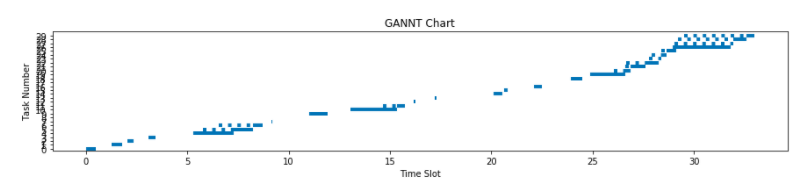


Running Simulation with mean arrival time = 1.0 and mean service time 0.6 ... 

Simulation Running ... 


-------------------------------------------------------------------------------------

Here is a display of the results of the simulation for illustration and debugging:


Number of Tasks: 30

Total Time: 32.9531




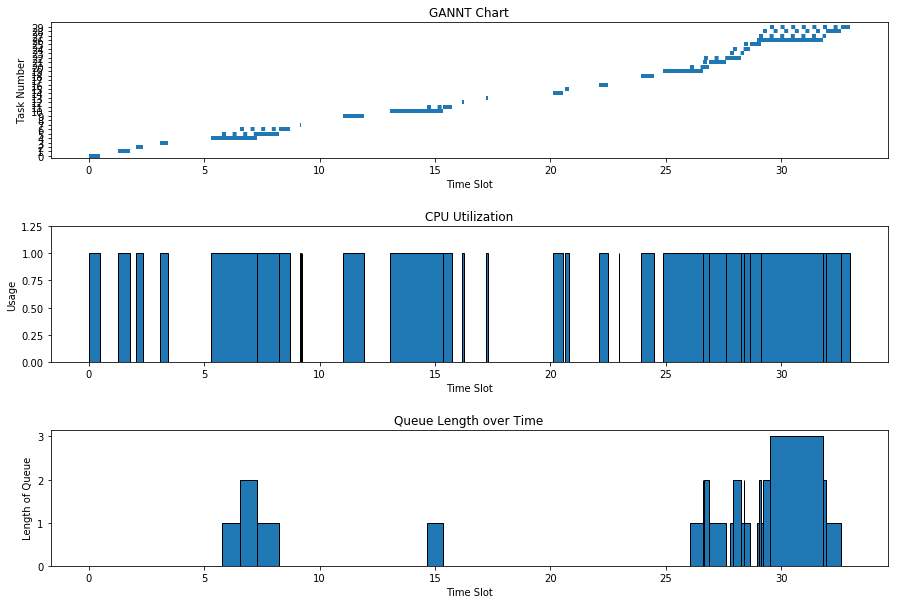

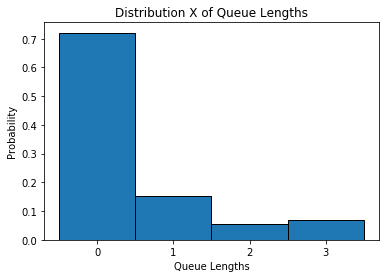

E[X]     = 0.4741
Var(X)   = 0.7778
stdev(X) = 0.8819

Mean Service Time: 0.6197

Mean Interarrival Time: 0.9839

CPU Utilization: 0.5642

Mean Wait Time: 0.5207

-------------------------------------------------------------------------------------

Here is a display of the statistics collected by analyzeResults(...):


Completed Task List:
Task #	Start	Service	Wait
0	0	0.4775	0
1	1.2559	0.5539	0.0
2	2.0431	0.3306	0.0
3	3.0813	0.3453	0.0
4	5.3048	1.9889	0.0
5	5.7884	0.9413	1.50534520833
6	6.5411	0.5037	1.69400878277
7	9.1393	0.0442	0.0
8	9.2305	0.0123	0.0
9	11.018	0.9035	0.0
10	13.0583	2.3071	0.0
11	14.6635	0.3714	0.70189354395
12	16.1801	0.0755	0.0
13	17.2015	0.0928	0.0
14	20.0959	0.4427	0.0
15	20.6315	0.1844	0.0
16	22.1198	0.3654	0.0
17	22.9601	0.0114	0.0
18	23.9215	0.5682	0.0
19	24.881	1.7267	0.0
20	26.0262	0.2673	0.581610088594
21	26.6007	0.7177	0.274388775475
22	26.6628	0.6593	0.92993816023
23	27.7734	0.1417	0.478688214971
24	27.9114	0.2274	0.482383550539
25	28.3635	0.5067	0.25765

In [10]:
# Change this line for number of tasks, 30 should be fine for this problem. 
num_tasks = 30              # Number of tasks

# Change this line for number of tasks, 0.06 should be fine for this problem. 
beta2 = 0.6        # Mean service time, exponentially distributed

# LEAVE THIS LINE THE SAME
beta1 = 1.0        # Mean inter-arrival time, exponentially distributed

seed(0)

print("\nRunning Simulation with mean arrival time = " + str(beta1) + " and mean service time " + str(beta2) + " ... ")

TS = getTaskList(num_tasks,beta1,beta2)

displaySimulation( TS )

## Problem Three: Analyzing the CPU Utilization

Now you will perform an experiment to analyze the CPU Utilization. You will run the simulation `num_trials`=$10^3$ times, recording the CPU utilization for each trial, and then plot the distribution of this data and report the mean value as a confidence interval. 

Note that for this problem and those following, you can generate *one* run
of a simulation in a "pipeline" as follows:

<pre>
results = analyzeResults( runSimulation( getTaskList(num_tasks,beta1,beta2) ) )
</pre>
and then we can extract the data as follows:
<pre>
totalTime = results[0]
meanServiceTime = results[1]
meanInterarrivalTime = results[2]
meanWaitTime = results[3]            
cpuUtilization = results[4]               
meanQueueLength = results[5]          
stdQueueLength = results[6]
</pre>

### Part (A)

Fill in the following to show the experimental distribution of CPU utilizations. 

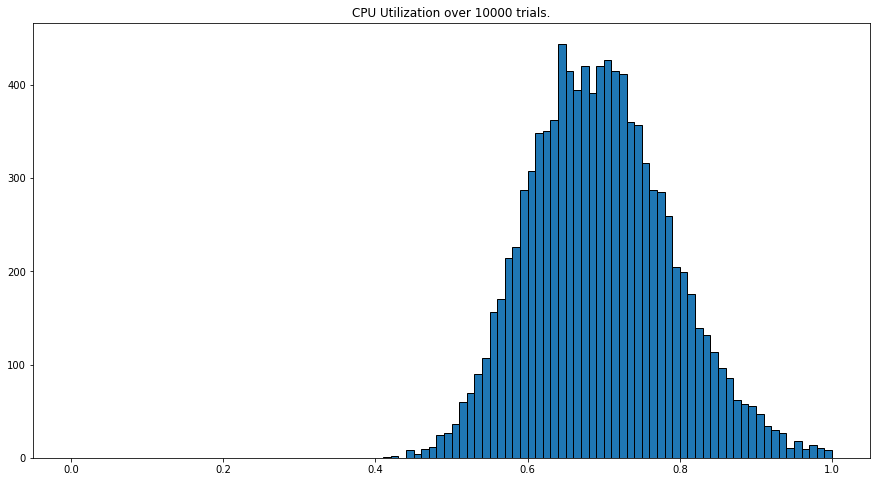

In [11]:
# Problem 3 (A) 

num_trials = 10**4       # Run with 10**2 to test, but Run All with 10**3 or higher before submitting

# Complete the following stub and simply print out the result shown

seed(0)

# Run num_trial simulation run, and collect
# a list of the kth statistic in the tuple returned by analyzeResults.
# num_tasks, beta1, and beta2 describe the initial task list

def getStat(k,num_tasks,beta1,beta2,num_trials):
    Res = [0]*num_trials
    for i in range(num_trials):
        results = analyzeResults( runSimulation( getTaskList(num_tasks,beta1,beta2) ) )
        Res[i] = results[k]
    return Res

num_tasks = 100
beta1 = 1.0
beta2 = 0.7

CP = getStat(4,num_tasks,beta1,beta2,num_trials)

plt.figure(figsize=(15,8))
plt.title("CPU Utilization over "+str(num_trials)+" trials.")
plt.hist(CP,bins=np.linspace(0,1,101),width=0.01,edgecolor='k')
print()

## Part (B) 

Run your experiment for `num_tasks` = 100, a sample size of 100, and beta2 = 0.7 and report the mean CPU utilization using an 
appropriate 95% confidence interval.

In [12]:
def cl2k(p):
    return norm.interval(alpha=p, loc=0, scale=1)[1]

In [13]:
# Important: You were SUPPOSED to run this for N (num_trials == N) and use the sample
# standard deviation to report the result....
seed(0)
num_tasks = 100
sample_size = 100
beta1 = 1.0
beta2 = 0.7
LOS = 0.95
seed(0)

CP = getStat(4,num_tasks,beta1,beta2,sample_size)
mu = mean(CP)
sigma = std(CP,ddof=1)
k = cl2k(LOS)
print("The mean CPU utilization is " + str(round4(mu)) + u" \u00B1 " + \
      str(round4(k*sigma/(num_tasks**0.5)))+" to "+str(LOS*100)+"% confidence.")

The mean CPU utilization is 0.694 ± 0.0183 to 95.0% confidence.


## Problem 4: Analyzing the Mean Wait Time

Now you must do the same thing as in the last problem, but analyze the data about the `meanWaitTime`. Submit two
answers exactly the same as in the previous problem, but analyzing the `meanWaitTime`,
and (in part B) with a sample size of 200 and LOS = 0.99 (all else the same).  

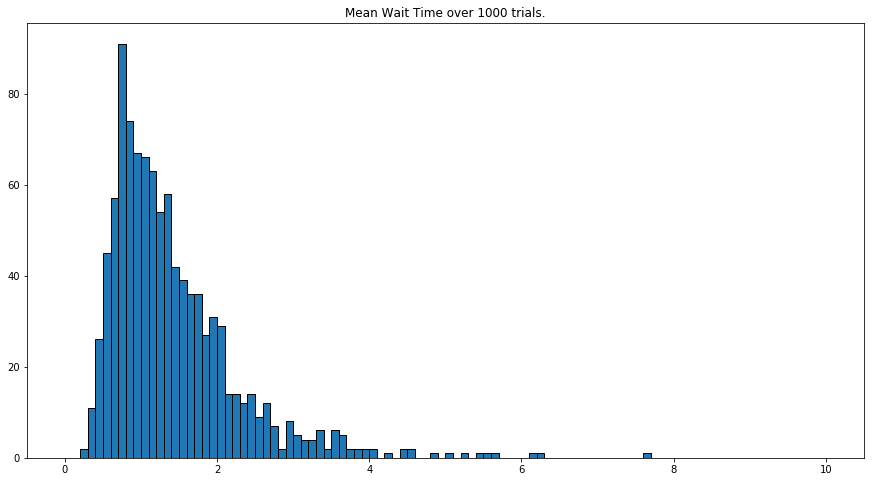

In [14]:
# Problem 4 (A) 

# Complete the following stub and simply print out the result shown
num_tasks = 100
num_trials = 10**3       # Run with 10**2 to test, but Run All with 10**3 before submitting
beta1 = 1.0
beta2 = 0.7
# Complete the following stub and simply print out the result shown

seed(0)

CP = getStat(3,num_tasks,beta1,beta2,num_trials)
plt.figure(figsize=(15,8))
plt.title("Mean Wait Time over "+str(num_trials)+" trials.")
plt.hist(CP,bins=np.linspace(0,10,101),width=0.1,edgecolor='k')
print()

In [15]:
# Problem 4 (B) 
seed(0)
num_tasks = 100
sample_size = 200
beta1 = 1.0
beta2 = 0.7
LOS = 0.99
seed(0)
CP = getStat(3,num_tasks,beta1,beta2,sample_size)
mu = mean(CP)
sigma = std(CP,ddof=1)
print(mu,sigma)
k = cl2k(LOS)
print("The mean wait time is " + str(round4(mu)) + u" \u00B1 " + \
      str(round4(k*sigma/(num_tasks**0.5)))+" to "+str(LOS*100)+"% confidence.")

NameError: name 'signa' is not defined

## Problem Five

Now we are going to run multiple trials of our simulation with different values of `beta2` (leaving `beta1` unchanged), and graph and analyze the results. 
The main issue we want to understand is what happens to various parameters as
the service time mean gets larger and exceeds the interarrival mean, forcing
the system into overload and longer and longer queues. 

In this problem, we will see the effect of changing <code>beta2</code> by graphing three different
result values against `beta2`. We will keep `beta1` = 1.0 as in previous problems. 


### Part (A)  

Complete the following code template to graph the CPU Utilization against `beta2`.


In [ ]:
"""  You may find the following useful: 

results = analyzeResults( runSimulation( getTaskList(numTasks,beta1,beta2) ) )
            
totalTime = results[0]
meanServiceTime = results[1]
meanInterarrivalTime = results[2]
meanWaitTime = results[3]            
cpuUtilization = results[4]               
meanQueueLength = results[5]          
stdQueueLength = results[6]

"""

        
# Plot the statistic at results[numStat] against the sequence of beta2 values in beta2_list

seed(0)

num_trials_inside_loop = 30           # try this at 20 or 30 if possible

def plotStat(numStat,numTasks,beta1,beta2_list,titl):

    # for each lam in lams, run the simulation and collect the statistic results[numStat] in a list,
    # then plot these against lams to see the effect of arrival rate on this statistic

    meanList = []

    for b in beta2_list:
        tot = 0
        for k in range(num_trials_inside_loop):
            finished = runSimulation( getTaskList(numTasks,beta1,b) )
            results = analyzeResults(finished)
            tot += results[numStat]
        meanList.append(tot/num_trials_inside_loop)

    
    plt.figure(figsize=(12, 3))
    plt.title(titl)
    plt.plot(beta2_list,meanList)
    plt.show()
     
numTasks = 500     # Try this at higher numbers, say 300 or 500

beta2_list = list(np.arange(0.25,2.0,0.05))   # the different values of beta2 to use in this problem
beta1 = 1.0                         # mean service time of arriving tasks -- do not change this parameter


plotStat(4,numTasks,beta1,beta2_list,titl="Mean CPU Utilization vs Mean Service Time")

### Part (B)

Answer these two questions (not looking for absolute precision here, just your impressions looking carefully at the data). 

   - What happens to the CPU Utilization as it approaches the overload point at 1.0?
   - What shape did the curve have before the overload point?
   
Hint: You will get a more accurate curve if you can increase the two parameters indicated. 

## Problem Six

Now (A) plot these parameters vs the mean service time:

  - Mean Wait Time
  - Mean Queue Length
  - Std of Queue Length

and (B) answer the following question:  "How do these behave as they exceed the overload point?  Do changes happen at the overload point or before?"

I am just looking for general observations, nothing too deep, just a couple of sentences of what you observe. 

In [ ]:
# Part (A)

seed(0)

num_trials_inside_loop = 20           # try this at 20 or 30 if possible

numTasks = 300     # Try this at higher numbers, say 300 or 500

plotStat(3,numTasks,beta1,beta2_list,titl="Mean Wait Time vs Mean Service Time")
plotStat(5,numTasks,beta1,beta2_list,titl="Mean Queue Length vs Mean Service Time")
plotStat(6,numTasks,beta1,beta2_list,titl="Std of Queue Length vs Mean Service Time")

**Answer to (B):**

Yes, the behavior we associated with overload--both increase in magnitude AND in the standard deviation--seems to start well before the overload point (beta1 == beta2). 

## Problem Seven

In this problem we are going to investigate <strong>Little's Law</strong>, which is described concisely in Wikipedia as follows:
<blockquote>
In queueing theory, a discipline within the mathematical theory of probability, Little's  law is a theorem by John Little which states that the long-term average number $L$ of customers in a stationary [i.e., not overloaded] system is equal to the long-term average effective arrival rate $\lambda$ multiplied by the average time $W$ that a customer spends in the system. Expressed algebraically the law is
</blockquote>

$$L=\lambda\cdot W$$


Translating this into our parameters, and noting that the CPU utilization = the mean number of tasks in the CPU, then we have

    - L = Average number of tasks in whole system = mean queue length + CPU utilization
    - W = Average time in whole system = mean wait time + mean service time

    
and where $\lambda = {1\over\text{beta1}}$. 

        
The importance of Little's Law is that it holds under a wide variety of different distributions, queueing disciplines, number of queues and servers, etc.   However, note that it is not stated to hold in an overloaded system -- we will find out whether it does! 

We are going to do the same experiment as above, but plot the ratio $R$ of the two
sides of the equation against `beta2`, which should be 1.0 according to Little's Law:

$$R = {L \over \lambda\cdot W} = {\text{beta1}\cdot L\over W}$$
        
Plot this against the same range of `beta2` values and answer the question: "Does Little's Law hold in overload?  Does it hold before the overload point?        

In [ ]:

num_trials_inside_loop = 10
    
def plotStatistics3(numTasks,beta1,beta2_list):

    ratioList = []

    for b in beta2_list:
        tot = 0
        for k in range(num_trials_inside_loop):
            finished = runSimulation( getTaskList(numTasks,beta1,b) )
            results = analyzeResults(finished)
            L = results[5] + results[4]
            W = results[3] + results[1]
            R = results[2] * L / W               # could use beta1 here
            tot += R
        ratioList.append(tot/num_trials_inside_loop)

    plt.figure(figsize=(12, 3))
    plt.title("Little's Ratio vs Mean Service Time")
    plt.plot(beta2_list,ratioList)
    plt.show()
    
    
    
    
numTasks = 2000             # More is definitely better here, try to get to 1000
beta2_list = list(np.arange(0.25,1.5,0.05))   
beta1 = 1.0                        # mean service time of arriving tasks -- do not change this parameter
    
plotStatistics3(numTasks,beta1,beta2_list)